#Digital Image Processing - 2
--------------------------------
Shivani S. Patil

##6.Implement Histogram Matching to adjust the contrast of an image to match another.

Upload source image:


Saving hu-chen-3yd8oXGoLqM-unsplash.jpg to hu-chen-3yd8oXGoLqM-unsplash (1).jpg
Upload reference image:


Saving matthew-spiteri-WfZ4WCuNtlg-unsplash.jpg to matthew-spiteri-WfZ4WCuNtlg-unsplash (1).jpg


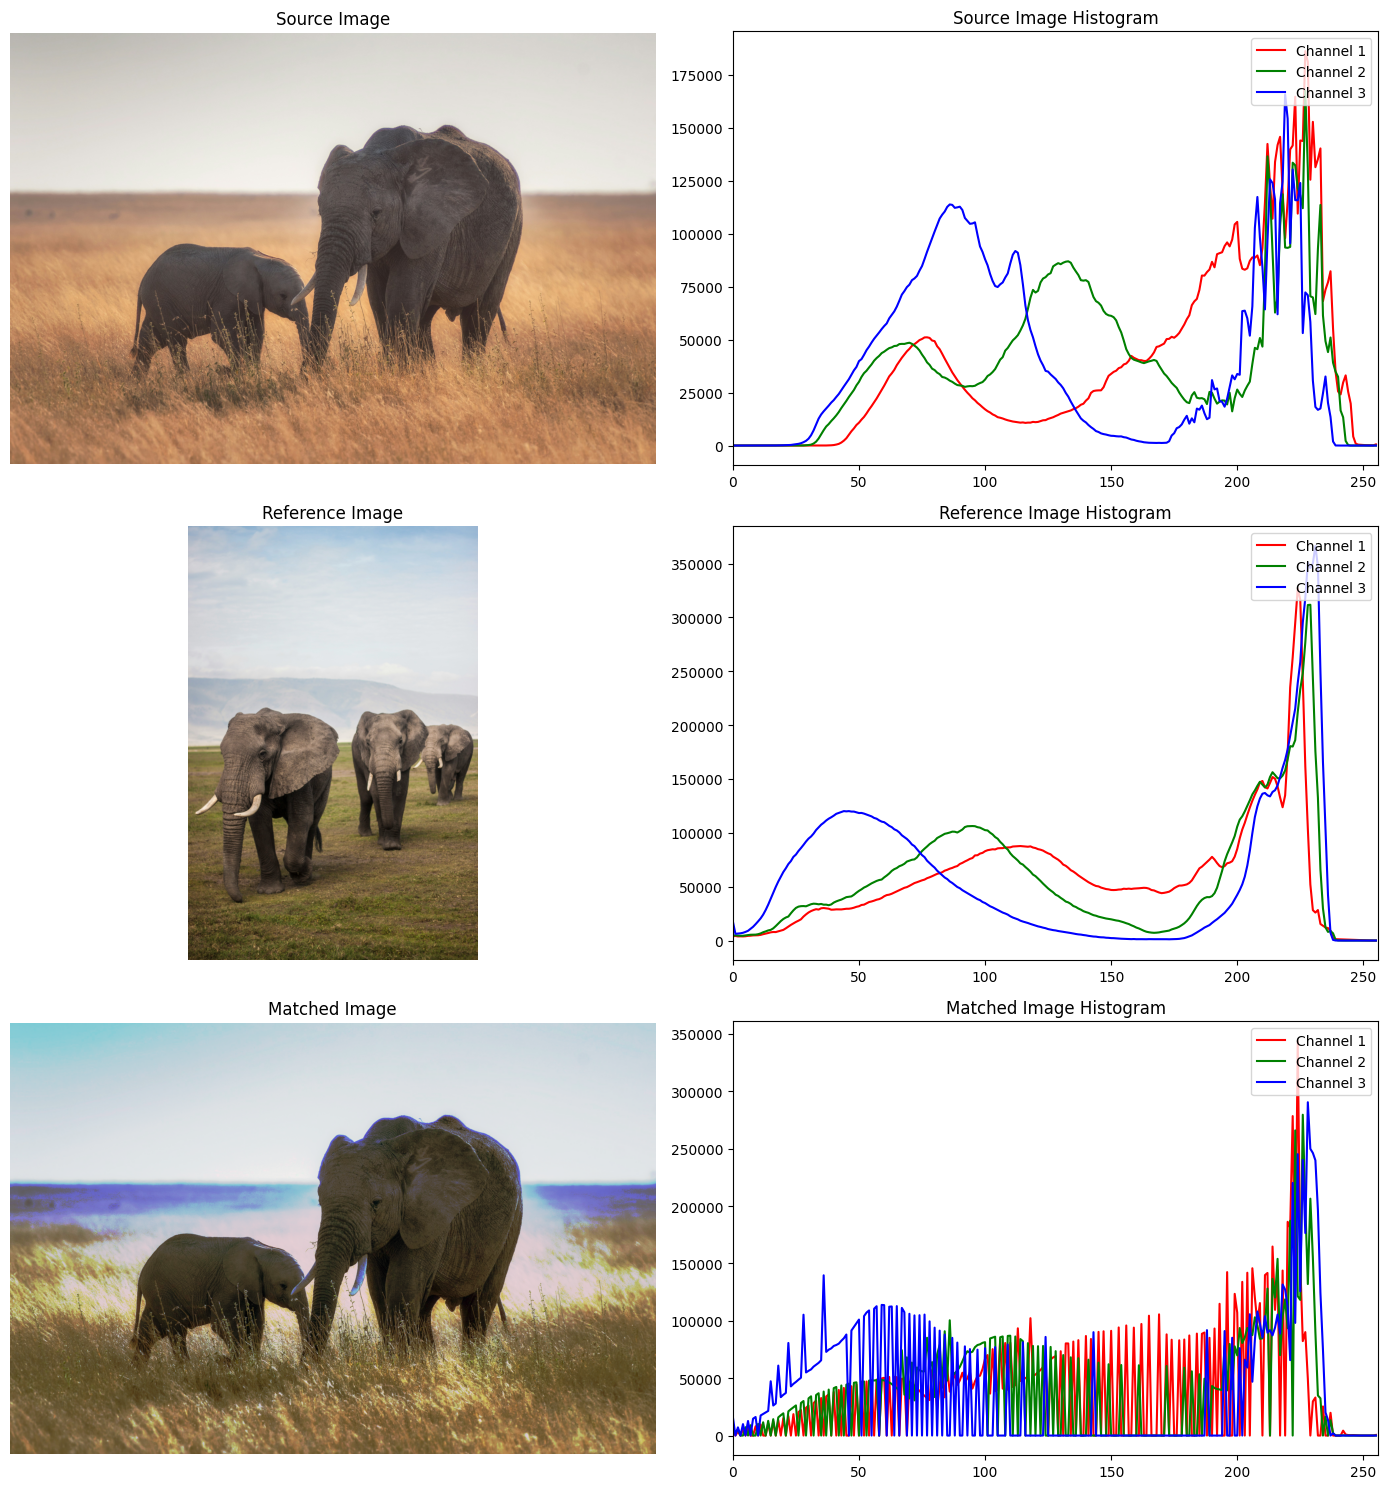

Matched image saved as 'matched_image.png'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 1. Install dependencies
!pip install scikit-image matplotlib

# 2. Imports
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure, img_as_ubyte

# 3. Upload images
from google.colab import files
print("Upload source image:")
src_upload = files.upload()
src_path = next(iter(src_upload))

print("Upload reference image:")
ref_upload = files.upload()
ref_path = next(iter(ref_upload))

# 4. Load images
source = io.imread(src_path)
reference = io.imread(ref_path)
multichannel = source.ndim == 3

# 5. Histogram Matching
matched = exposure.match_histograms(source, reference, channel_axis=-1 if multichannel else None)

# 6. Helper: Plot image and its RGB histograms
def plot_img_and_hist(img, ax_img, ax_hist, title):
    ax_img.imshow(img, cmap='gray' if img.ndim==2 else None)
    ax_img.set_title(title)
    ax_img.axis('off')

    colors = ('r','g','b') if img.ndim==3 else ('k',)
    for i, color in enumerate(colors):
        channel = img[:,:,i] if img.ndim==3 else img
        hist, bins = np.histogram(channel.flatten(), bins=256, range=[0,255])
        ax_hist.plot(hist, color=color, label=f'Channel {i+1}')
    ax_hist.set_xlim([0, 256])
    ax_hist.set_title(f"{title} Histogram")
    ax_hist.legend(loc='upper right')

# 7. Display all images and their histograms
fig, axs = plt.subplots(3, 2, figsize=(14, 15))
plot_img_and_hist(source, axs[0,0], axs[0,1], 'Source Image')
plot_img_and_hist(reference, axs[1,0], axs[1,1], 'Reference Image')
plot_img_and_hist(matched, axs[2,0], axs[2,1], 'Matched Image')
plt.tight_layout()
plt.show()

# 8. Save and offer download
io.imsave('matched_image.png', img_as_ubyte(matched))
print("Matched image saved as 'matched_image.png'")
files.download('matched_image.png')

###7.Develop Spatial and Frequency Domain Techniques for Image Contrast Enhancement and Noise Reduction.

Upload an image (color or grayscale):


Saving matthew-spiteri-WfZ4WCuNtlg-unsplash.jpg to matthew-spiteri-WfZ4WCuNtlg-unsplash (4).jpg


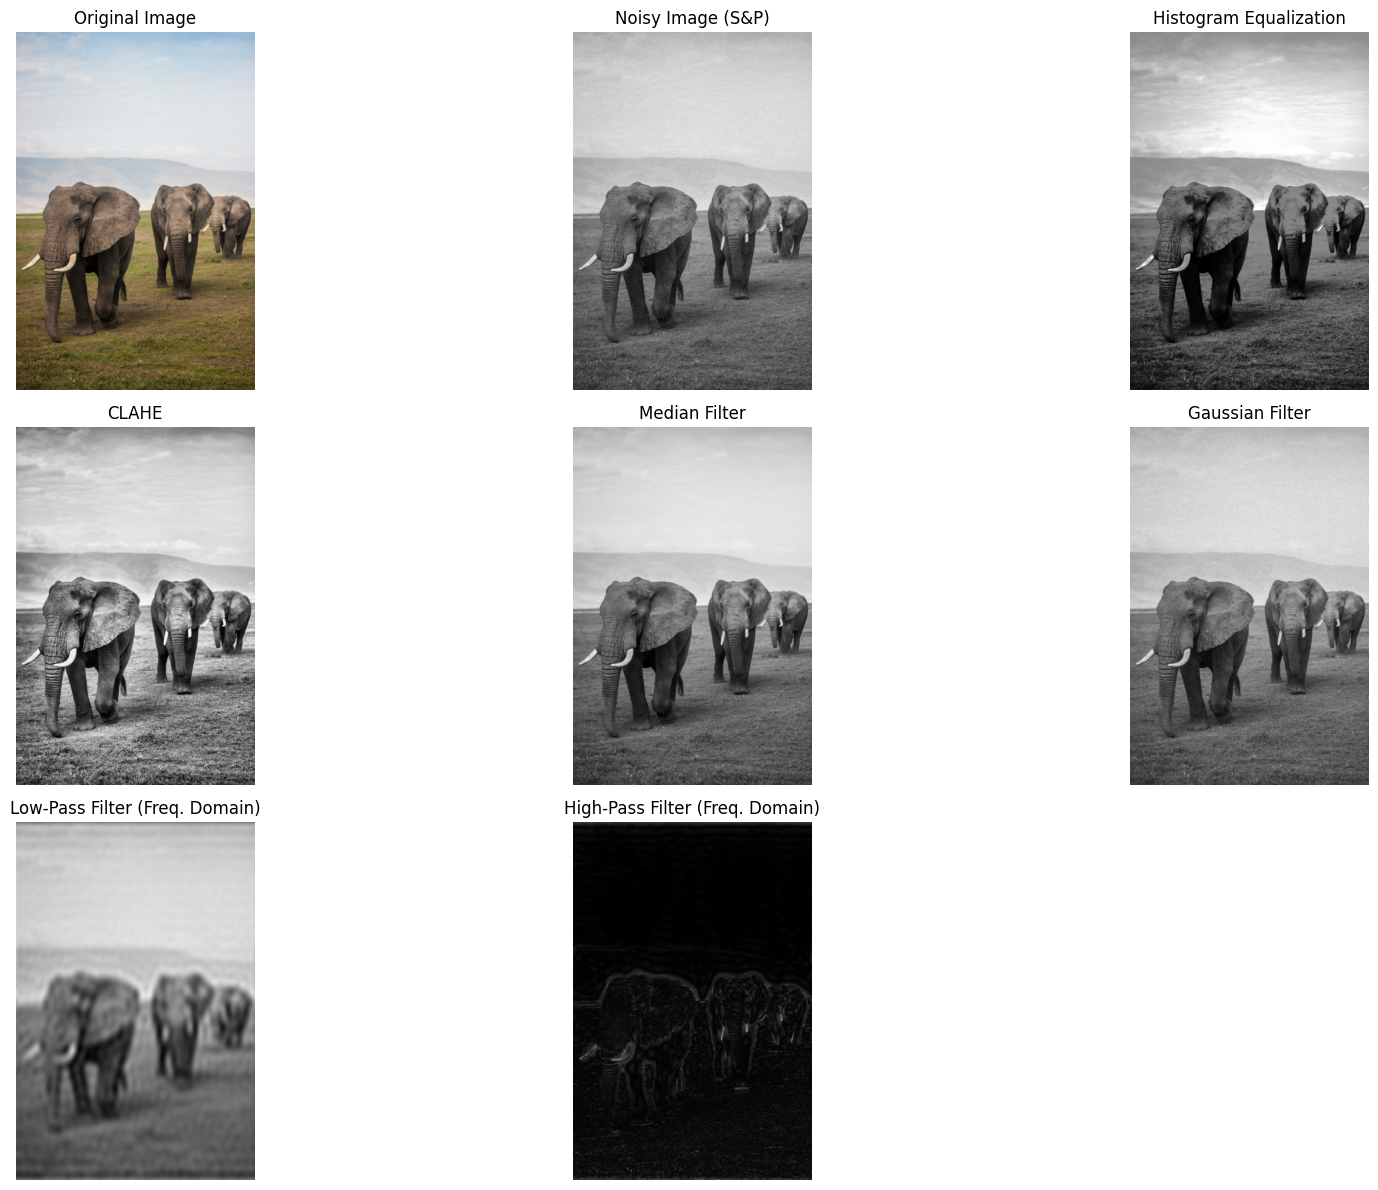

In [ ]:
# 1. Install requirements
!pip install scikit-image matplotlib opencv-python --quiet

# 2. Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io, exposure, img_as_ubyte, color, util

# 3. Upload and load image
from google.colab import files
print("Upload an image (color or grayscale):")
uploaded = files.upload()
img_path = next(iter(uploaded))
img = io.imread(img_path)

# 4. Fix for display: always scale to [0,255] uint8 for both gray and color
def to_uint8(im):
    if im.dtype == np.uint8:
        return im
    elif im.max() <= 1.0:
        return img_as_ubyte(im)
    else:
        return (255 * (im / im.max())).astype(np.uint8)

img_disp = to_uint8(img)
is_color = img_disp.ndim == 3

# 5. Prepare grayscale for processing
if is_color:
    img_gray = color.rgb2gray(img_disp)
    img_gray = img_as_ubyte(img_gray)
else:
    img_gray = img_disp

# 6. Add synthetic noise (for demo)
noisy_img = util.random_noise(img_gray, mode='s&p', amount=0.08)
noisy_img = img_as_ubyte(noisy_img)

# -------- Spatial domain (gray) --------
hist_eq = exposure.equalize_hist(img_gray)
hist_eq = img_as_ubyte(hist_eq)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img_gray)
median_denoised = cv2.medianBlur(noisy_img, 3)
gaussian_denoised = cv2.GaussianBlur(noisy_img, (5,5), sigmaX=1.5)

# -------- Frequency domain (gray) --------
def low_pass_filter(img, radius=30):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    rows, cols = img.shape
    crow, ccol = rows//2 , cols//2
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, -1)
    fshift = fshift * mask
    img_back = np.fft.ifft2(np.fft.ifftshift(fshift))
    img_back = np.abs(img_back)
    img_back = np.clip(img_back, 0, 255)
    return img_back.astype(np.uint8)

def high_pass_filter(img, radius=20):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    rows, cols = img.shape
    crow, ccol = rows//2 , cols//2
    mask = np.ones((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 0, -1)
    fshift = fshift * mask
    img_back = np.fft.ifft2(np.fft.ifftshift(fshift))
    img_back = np.abs(img_back)
    img_back = np.clip(img_back, 0, 255)
    return img_back.astype(np.uint8)

low_pass_img = low_pass_filter(noisy_img)
high_pass_img = high_pass_filter(img_gray)

# -------- Display results --------
def show_img(title, img, pos, cmap=None):
    ax = plt.subplot(3, 3, pos)
    if img.ndim == 2:
        ax.imshow(img, cmap=cmap or 'gray', vmin=0, vmax=255)
    else:
        ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.figure(figsize=(18, 12))
show_img('Original Image', img_disp, 1, None if is_color else 'gray')
show_img('Noisy Image (S&P)', noisy_img, 2, 'gray')
show_img('Histogram Equalization', hist_eq, 3, 'gray')
show_img('CLAHE', clahe, 4, 'gray')
show_img('Median Filter', median_denoised, 5, 'gray')
show_img('Gaussian Filter', gaussian_denoised, 6, 'gray')
show_img('Low-Pass Filter (Freq. Domain)', low_pass_img, 7, 'gray')
show_img('High-Pass Filter (Freq. Domain)', high_pass_img, 8, 'gray')
plt.tight_layout()
plt.show()

#**OPEN - ENDED** **Experiment**

###8.In textile manufacturing, automated fabric defect detection is crucial for quality control. Common defects include holes, stains, wrinkles, and weave irregularities. Apply image processing and computer vision technique to facilitate

100%|██████████| 1.73G/1.73G [00:23<00:00, 78.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/k213080/fabric-defect-dataset/versions/1
Found 1954 image files.
Image: 13.jpg - Defect counts: {'stain': 6, 'wrinkle': 1, 'hole': 9}


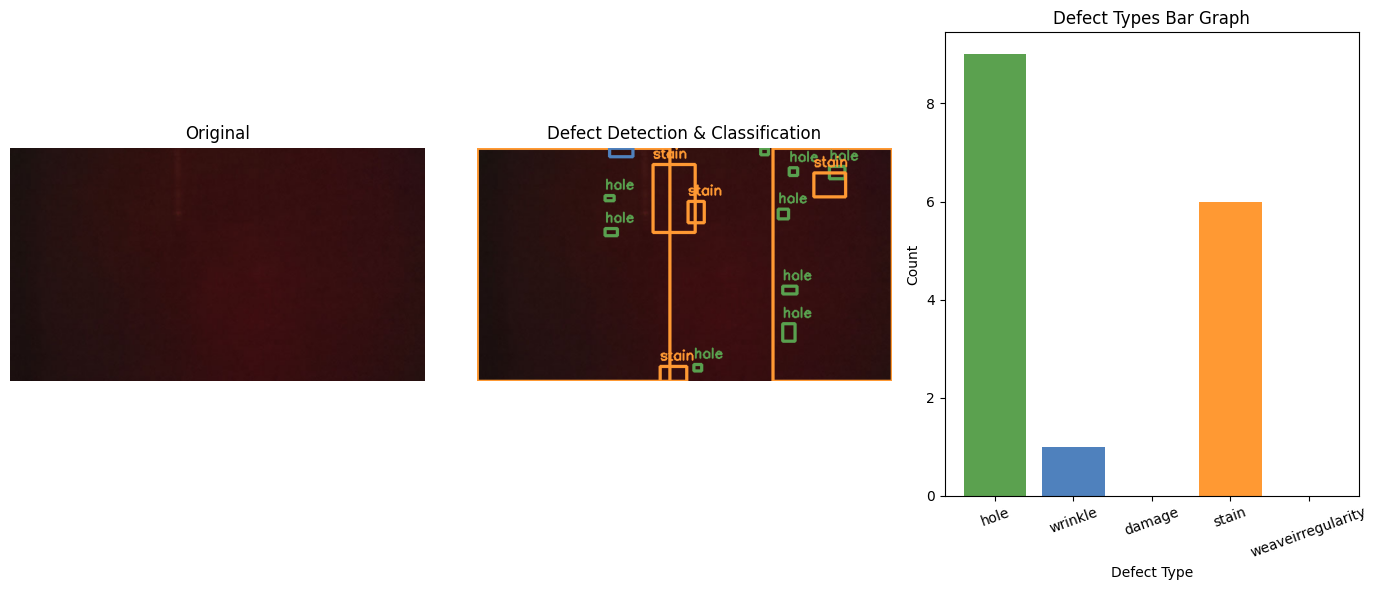

In [ ]:
import kagglehub
import os
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte, exposure, filters, morphology, measure, color
import numpy as np
import cv2
from collections import Counter

# Download the dataset
path = kagglehub.dataset_download("k213080/fabric-defect-dataset")
print("Path to dataset files:", path)

def list_all_images(dataset_path):
    valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.gif', '.JPG', '.PNG')
    all_images = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(valid_exts):
                all_images.append(os.path.join(root, file))
    return all_images

all_images = list_all_images(path)
print(f"Found {len(all_images)} image files.")
if not all_images:
    raise FileNotFoundError("No image files found in the dataset directory.")

def classify_defect(prop, original_img, region_mask):
    area = prop.area
    minr, minc, maxr, maxc = prop.bbox
    bbox_area = (maxr - minr) * (maxc - minc)
    aspect = (maxc - minc) / (maxr - minr + 1e-5)
    solidity = prop.solidity if hasattr(prop, "solidity") else 0
    eccentricity = prop.eccentricity if hasattr(prop, "eccentricity") else 0

    # Region mean intensity (useful for stains)
    region_intensity = np.mean(original_img[region_mask])
    region_std = np.std(original_img[region_mask])
    # For colored images, use intensity from value channel in HSV
    if original_img.ndim == 3 and original_img.shape[2] == 3:
        hsv = color.rgb2hsv(original_img)
        region_intensity = np.mean(hsv[...,2][region_mask])
        region_std = np.std(hsv[...,2][region_mask])

    # Heuristics for defect type
    if area > 500 and solidity < 0.8 and region_std > 0.15:
        return "damage"  # Irregular, not solid, high texture: likely tear/damage
    elif eccentricity > 0.92 and aspect > 2:
        return "wrinkle"  # Very long/thin region, high eccentricity
    elif area < 400 and 0.7 < solidity < 1.1:
        return "hole"     # Small, solid and roundish
    elif region_std < 0.07 and area > 100 and region_intensity < 0.5:
        return "stain"    # Low texture, dark region
    elif 0.8 < solidity < 1.0 and 1.1 < aspect < 3 and area > 200:
        return "weaveirregularity"  # Moderate aspect, moderate area, fairly solid
    else:
        return "damage"

def detect_and_classify(img_path, rect_color=(50, 100, 200)):
    img = io.imread(img_path)
    # Ensure display and grayscale
    if img.ndim == 2:
        img_disp = np.stack([img_as_ubyte(img)]*3, axis=-1)
        gray = img_as_ubyte(img)
    elif img.ndim == 3 and img.shape[2] == 1:
        img_disp = np.repeat(img, 3, axis=2)
        gray = img_as_ubyte(img[:, :, 0])
    else:
        img_disp = img
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if img.shape[2] == 3 else img[:, :, 0]
    # Enhance and denoise
    gray_eq = img_as_ubyte(exposure.equalize_adapthist(gray, clip_limit=0.03))
    blur = cv2.GaussianBlur(gray_eq, (5,5), 0)
    thresh_val = filters.threshold_otsu(blur)
    binary = (blur < thresh_val).astype(np.uint8) * 255
    cleaned = morphology.remove_small_objects(binary.astype(bool), min_size=80)
    cleaned = morphology.binary_closing(cleaned, morphology.disk(4))
    cleaned = morphology.binary_opening(cleaned, morphology.disk(2))
    cleaned = img_as_ubyte(cleaned)
    labels = measure.label(cleaned, connectivity=2)
    props = measure.regionprops(labels)
    img_out = img_disp.copy()
    defect_types = []
    for prop in props:
        minr, minc, maxr, maxc = prop.bbox
        if (maxr - minr) * (maxc - minc) > 100:
            region_mask = (labels[minr:maxr, minc:maxc] == prop.label)
            defect_type = classify_defect(prop, img[minr:maxr, minc:maxc], region_mask)
            defect_types.append(defect_type)
            color_map = {
                "hole": (89, 161, 79),
                "wrinkle": (79, 129, 189),
                "damage": (196, 79, 79),
                "stain": (255, 153, 51),
                "weaveirregularity": (153, 51, 255)
            }
            color = color_map.get(defect_type, (100, 100, 100))
            cv2.rectangle(img_out, (minc, minr), (maxc, maxr), color, 4)
            cv2.putText(img_out, defect_type, (minc, minr-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    return img_disp, img_out, defect_types, os.path.basename(img_path)

# Process one image for demonstration (change index for others)
img_idx = 0
orig, defect_img, defect_types, name = detect_and_classify(all_images[img_idx])

# Print counts for each defect type
counts = Counter(defect_types)
print(f"Image: {name} - Defect counts: {dict(counts)}")

# Plot
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.imshow(orig)
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(defect_img)
plt.title("Defect Detection & Classification")
plt.axis('off')

plt.subplot(1,3,3)
# Use clear, colorblind-friendly palette
bar_colors = ['#5ba14f', '#4f81bd', '#c44f4f', '#ff9933', '#9933ff']
labels = ["hole", "wrinkle", "damage", "stain", "weaveirregularity"]
plt.bar(labels, [counts.get(l,0) for l in labels], color=bar_colors)
plt.title("Defect Types Bar Graph")
plt.ylabel("Count")
plt.xlabel("Defect Type")
plt.xticks(labels, rotation=20)
plt.tight_layout()
plt.show()

##9.Realize ADAS feature: hump detection, pothole detection, drench detection etc,.

Hump detection

In [ ]:
pip install opencv-python


Enter the path to your road image: /content/drive/MyDrive/3-Figure1-1.png


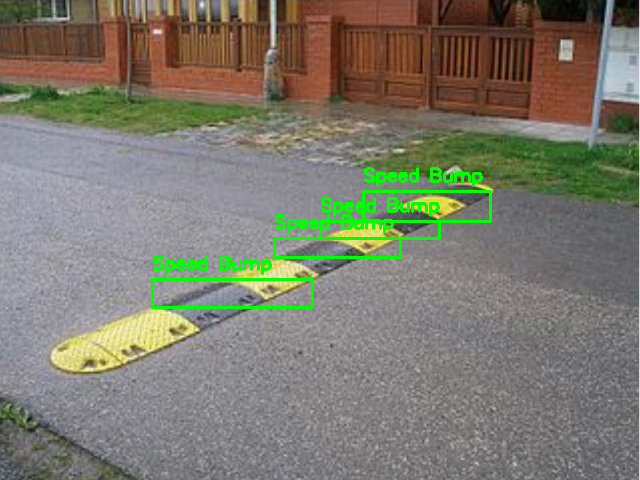

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Input image path
image_path = input("Enter the path to your road image: ")

# Load the image
image = cv2.imread(image_path)
original = image.copy()

# Resize for consistency
image = cv2.resize(image, (640, 480))

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Edge detection (Canny)
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours that look like bumps (heuristic: flat and wide)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)

    # Speed bumps are usually wide and low
    if 100 < w < 500 and 10 < h < 80 and 3 < aspect_ratio < 10:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, "Speed Bump", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Show result in Colab
cv2_imshow(image)


Enter the path to your road image: /content/drive/MyDrive/2.jpg


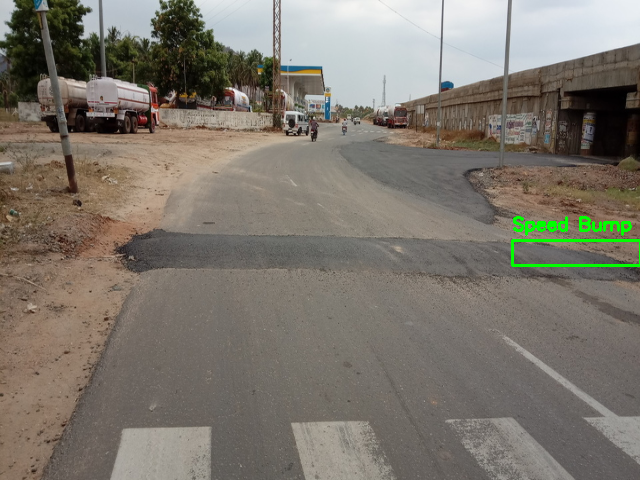

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Input image path
image_path = input("Enter the path to your road image: ")

# Load the image
image = cv2.imread(image_path)
original = image.copy()

# Resize for consistency
image = cv2.resize(image, (640, 480))

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Edge detection (Canny)
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours that look like bumps (heuristic: flat and wide)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)

    # Speed bumps are usually wide and low
    if 100 < w < 500 and 10 < h < 80 and 3 < aspect_ratio < 10:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, "Speed Bump", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Show result in Colab
cv2_imshow(image)


Pothole detection


In [ ]:
# Install necessary libraries in Colab
!pip install tensorflow opencv-python

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import files
from PIL import Image
import io

# Load a pre-trained model (for demonstration, you may need to fine-tune your own for pothole detection)
# For now, use MobileNetV2 as a placeholder.
model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True)

# Function to preprocess image for MobileNetV2
def prepare_image(image, target_size=(224, 224)):
    image = image.resize(target_size)
    image = np.array(image)
    if image.shape[-1] == 4:
        image = image[..., :3]  # remove alpha channel if present
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Upload an image
uploaded = files.upload()
for fname in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[fname]))
    input_image = prepare_image(image)
    preds = model.predict(input_image)
    decoded = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=3)[0]
    print(f"Predictions for {fname}:")
    for (imagenetID, label, prob) in decoded:
        print(f"{label}: {prob*100:.2f}%")
    # Show the image
    display(image)

# NOTE: For actual pothole detection, you would need a pothole-specific trained model.
# You can replace MobileNetV2 with your own model and modify the prediction/labeling logic accordingly.

Output hidden; open in https://colab.research.google.com to view.

Pothole defect


Saving pothole_5.jpg to pothole_5 (11).jpg


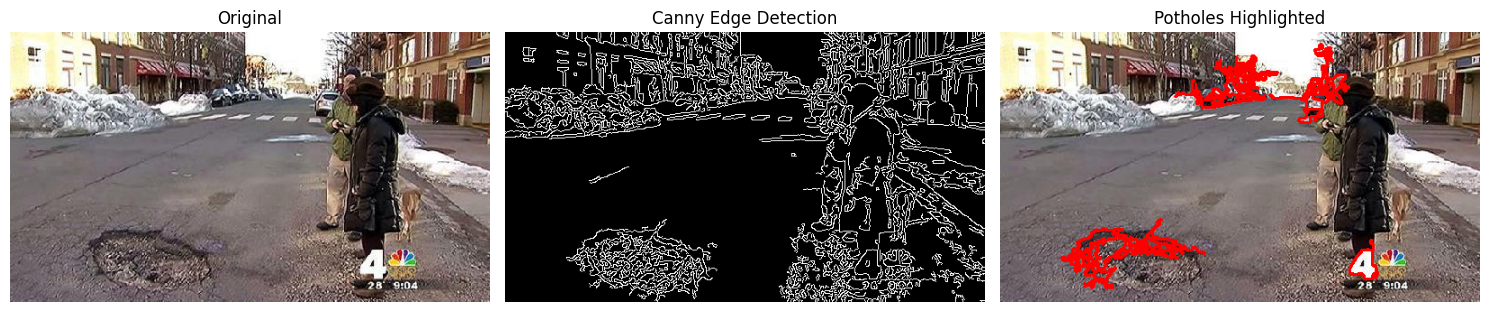

In [ ]:
# Step 1: Install libraries
!pip install opencv-python matplotlib

# Step 2: Import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Step 3: Upload multiple images
uploaded = files.upload()

# Step 4: Define pothole detection function using edge detection
def detect_potholes(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result = image.copy()

    pothole_found = False
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 500 < area < 3000:  # Area-based filter
            cv2.drawContours(result, [cnt], -1, (0, 0, 255), 2)  # Red contour
            pothole_found = True

    return edges, result, pothole_found

# Step 5: Process each image and show 3-panel results
for filename in uploaded.keys():
    img = cv2.imread(filename)
    if img is None:
        print(f"❌ Couldn't load: {filename}")
        continue

    edges, result_img, detected = detect_potholes(img)

    # Display all 3 views
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edge Detection")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Potholes Highlighted" if detected else "No Potholes Detected")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
